In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/SUTD hackathon/")

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

import PIL.Image as Image

import matplotlib.pyplot as plt

In [5]:
data_dir = '/content/drive/MyDrive/SUTD hackathon/dataset-resized'

IMAGE_SHAPE = (224,224)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


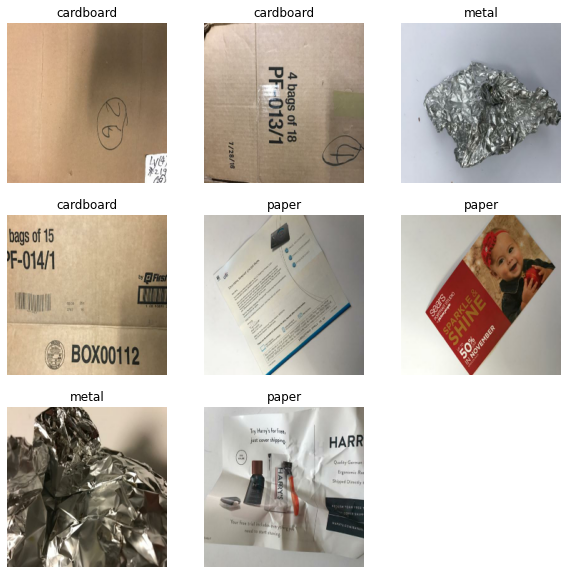

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2)),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
base_model = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False, input_shape=(224,224,3) )

image_batch, label_batch = next(iter(train_ds))

feature_batch = base_model(image_batch)

print(feature_batch.shape)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 426

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


(8, 7, 7, 1024)
Number of layers in the base model:  427


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(8, 1024)


In [13]:
prediction_layer = tf.keras.layers.Dense(6,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 6)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 6,150
Non-trainable params: 7,037,504
_______________________________________________

In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

In [22]:
model.load_weights(checkpoint_path)

learning_rate=0.000025
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

checkpoint_path = "/content/drive/MyDrive/SUTD hackathon/caleb2_path"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [23]:

history = model.fit(
                    train_ds, 
                    validation_data=val_ds, 
                    epochs=100, 
                    batch_size=16,
                    callbacks=[cp_callback]

 )

Epoch 1/100
253/253 [==============================] - 35s 110ms/step - loss: 0.2719 - accuracy: 0.9075 - val_loss: 0.4573 - val_accuracy: 0.8475

Epoch 00001: saving model to /content/drive/MyDrive/SUTD hackathon/caleb2_path
Epoch 2/100
253/253 [==============================] - 26s 102ms/step - loss: 0.2585 - accuracy: 0.9144 - val_loss: 0.4566 - val_accuracy: 0.8475

Epoch 00002: saving model to /content/drive/MyDrive/SUTD hackathon/caleb2_path
Epoch 3/100
253/253 [==============================] - 26s 101ms/step - loss: 0.2711 - accuracy: 0.9036 - val_loss: 0.4569 - val_accuracy: 0.8475

Epoch 00003: saving model to /content/drive/MyDrive/SUTD hackathon/caleb2_path
Epoch 4/100
253/253 [==============================] - 26s 100ms/step - loss: 0.2651 - accuracy: 0.9080 - val_loss: 0.4564 - val_accuracy: 0.8475

Epoch 00004: saving model to /content/drive/MyDrive/SUTD hackathon/caleb2_path
Epoch 5/100
253/253 [==============================] - 26s 101ms/step - loss: 0.2700 - accuracy:

KeyboardInterrupt: ignored

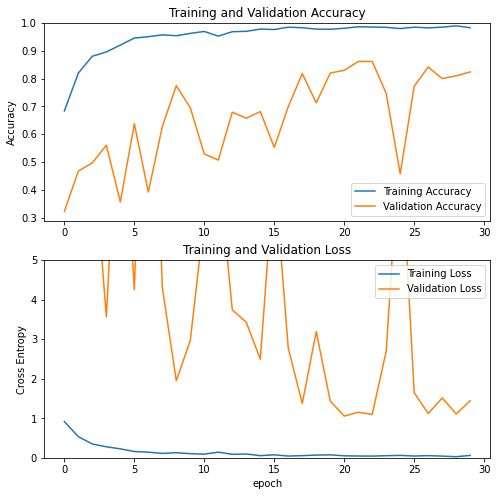

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [24]:
model.load_weights(checkpoint_path)
model.save('caleb_py/caleb.h5')

In [ ]:
pred = []
for i in predictions:
    pred.append(np.argmax(i))

Predictions:
 [0, 3, 4, 2, 3, 4, 4, 1, 3, 4, 1, 2, 0, 3, 2, 0]
Labels:
 [0, 3, 4, 2, 4, 4, 4, 1, 3, 4, 1, 2, 0, 3, 2, 0]


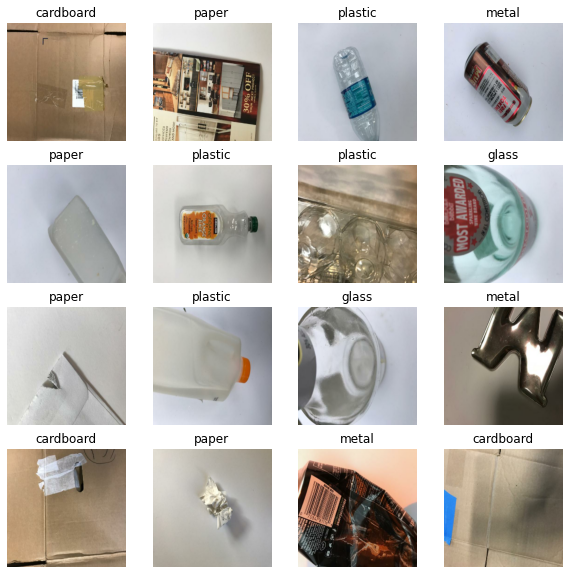

In [ ]:
print('Predictions:\n', pred)
print('Labels:\n', list(label_batch))

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")